<a href="https://colab.research.google.com/github/sylpx/Deep-Learning-Tugas-2/blob/main/Tugas%20Deep%20Learning%20Agniel%20Lorensyus_Malino%20(HyperParameter).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Install dan import library
!pip install gdown --quiet
!pip install tensorflow --quiet

import tensorflow as tf
import gdown
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
import os
import matplotlib.pyplot as plt

In [2]:
# 2. Upload dataset zip
file_id = "13OMC0kC0ibt-cqm1wfpchuV5LZUFHZAO"
url = f"https://drive.google.com/uc?export=download&id={file_id}"

gdown.download(url, "DATASETGAMBAR.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=13OMC0kC0ibt-cqm1wfpchuV5LZUFHZAO
From (redirected): https://drive.google.com/uc?export=download&id=13OMC0kC0ibt-cqm1wfpchuV5LZUFHZAO&confirm=t&uuid=4093a946-a83b-45c3-9f6a-0328bec37867
To: /content/DATASETGAMBAR.zip
100%|██████████| 38.8M/38.8M [00:01<00:00, 29.6MB/s]


'DATASETGAMBAR.zip'

In [3]:
# 3. Ekstrak dataset
import zipfile

with zipfile.ZipFile("DATASETGAMBAR.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [4]:
import shutil
import random
from pathlib import Path

# Path awal dataset setelah diekstrak
original_dataset_dir = Path("dataset/DATASET GAMBAR (resize)")

# Tujuan folder baru
base_dir = Path("dataset/split_dataset")
train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"

# Buat folder train, val, dan test
for folder in [train_dir, val_dir, test_dir]:
    folder.mkdir(parents=True, exist_ok=True)

# Rasio split
val_split = 0.2  # 20% untuk validasi
test_split = 0.2 # 10% untuk testing

# Untuk setiap kelas
for class_dir in original_dataset_dir.iterdir():
    if class_dir.is_dir():
        images = list(class_dir.glob("*"))
        random.shuffle(images)

        class_name = class_dir.name

        # Hitung jumlah data
        total = len(images)
        val_count = int(total * val_split)
        test_count = int(total * test_split)
        train_count = total - val_count - test_count

        # Bagi dataset
        train_images = images[:train_count]
        val_images = images[train_count:train_count+val_count]
        test_images = images[train_count+val_count:]

        # Buat subfolder kelas di masing-masing folder tujuan
        for subset, subset_images in zip(
            [train_dir, val_dir, test_dir],
            [train_images, val_images, test_images]
        ):
            class_subset_dir = subset / class_name
            class_subset_dir.mkdir(parents=True, exist_ok=True)
            for img in subset_images:
                shutil.copy(img, class_subset_dir)


In [5]:
# 4. Definisikan path dataset
data_dir = "dataset/split_dataset"
img_width, img_height = 224, 224  # Ukuran yang lebih umum untuk CNN
batch_size = 50

In [6]:
# 5. Preprocessing dan split dataset (train/validation)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'val'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 720 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


In [7]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Hitung class weights
class_weights = compute_class_weight('balanced',
                                   classes=np.unique(train_generator.classes),
                                   y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0)}


In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2  # <-- Import l2 di sini

# Preprocessing input khusus ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Pastikan ukuran input sesuai dengan ResNet50 (224x224)
img_height, img_width = 224, 224

# Membangun model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

# Freeze base model
base_model.trainable = False

# Bangun model lengkap dengan Input layer eksplisit
model = models.Sequential([
    Input(shape=(img_height, img_width, 3)),  # <-- Tambahkan Input layer
    layers.Lambda(preprocess_input),  # <-- Hapus input_shape di Lambda
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

# Kompilasi
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()  # Cek struktur model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
# 8. Training model dengan EarlyStopping dan ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

epochs = 50  # Naikkan epoch karena ada early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights  # Tambahkan ini
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.2746 - loss: 6.2848 - val_accuracy: 0.2500 - val_loss: 5.5890 - learning_rate: 1.0000e-04
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 841ms/step - accuracy: 0.2258 - loss: 5.7546 - val_accuracy: 0.2458 - val_loss: 5.2530 - learning_rate: 1.0000e-04
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 835ms/step - accuracy: 0.2385 - loss: 5.3749 - val_accuracy: 0.3250 - val_loss: 4.9396 - learning_rate: 1.0000e-04
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 797ms/step - accuracy: 0.2673 - loss: 4.9713 - val_accuracy: 0.2875 - val_loss: 4.6501 - learning_rate: 1.0000e-04
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 770ms/step - accuracy: 0.2246 - loss: 4.6906 - val_accuracy: 0.2458 - val_loss: 4.3806 - learning_rate: 1.0000e-04
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 822ms/step - accuracy: 0.2682 - loss: 4.4469 - val_accuracy: 0.3333 - val_loss: 4.1376 - learning_rate: 1.0000e-04
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 765ms/step - accura

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - accuracy: 0.9819 - loss: 0.2165
Test Accuracy: 98.33%


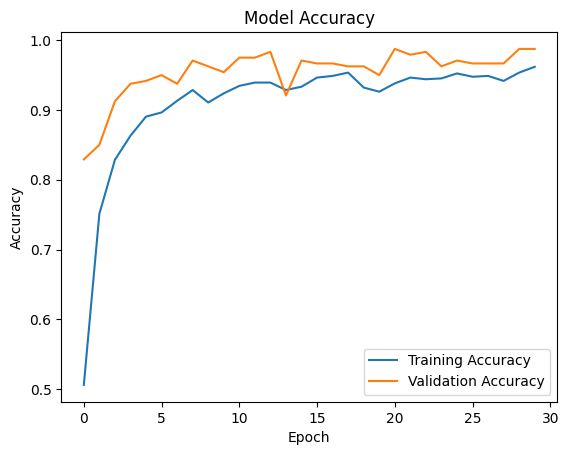

In [ ]:
# 9. Visualisasi akurasi dan loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step


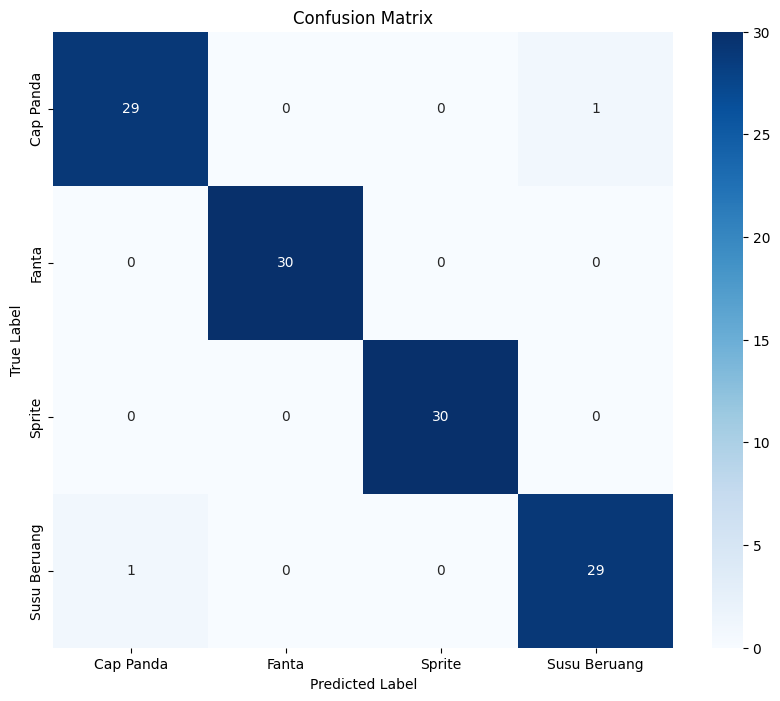


Classification Report:
              precision    recall  f1-score   support

   Cap Panda       0.97      0.97      0.97        30
       Fanta       1.00      1.00      1.00        30
      Sprite       1.00      1.00      1.00        30
Susu Beruang       0.97      0.97      0.97        30

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



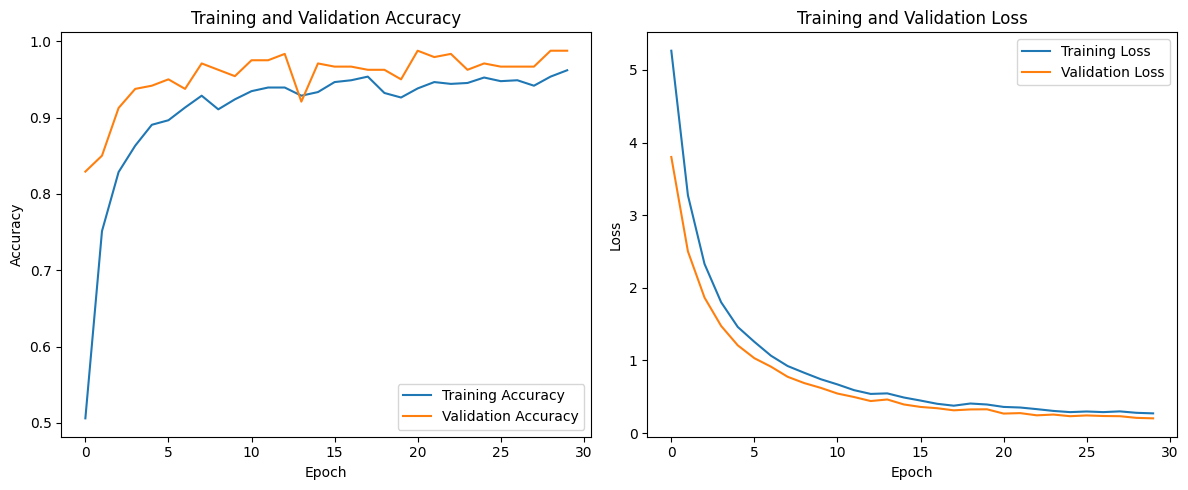

In [ ]:
# Evaluasi model dengan confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Prediksi pada data test
test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)

# Dapatkan true classes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Buat confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Grafik akurasi dan loss yang lebih lengkap
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 10. Simpan model
model.save("model_klasifikasi_4kelas.h5")
print("Model saved!")


Model saved!
